<a href="https://colab.research.google.com/github/anujbhandari2/ECS171-Final-Project/blob/main/ECS_171_Final_Project_Transformer_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bitcoin Price Prediction with a Transformer Model

## This notebook demonstrates an end-to-end pipeline for forecasting **daily Bitcoin price**
## (continuous variable) using a Transformer architecture in PyTorch.

# Features / Steps:
## 1. **Load and explore** dataset (Date, Open, High, Low, Close, Volume).
## 2. **Data cleaning** and optional **feature engineering** (technical indicators).
## 3. **Scaling** for better neural network training.
## 4. **Windowing** (past N days) and **horizon setting** (predict next 1 day).
##    - Easily extendable to multi-step forecasting (e.g., next 7 days).
## 5. **Transformer Model**:
##    - Multi-head self-attention, positional encodings.
##    - Robust architecture with recommended hyperparameters.
## 6. **Training** with early stopping & learning rate scheduler.
## 7. **Testing & evaluation** using MSE, MAE, RMSE, and MAPE.
## 8. **Plotting** predictions vs. actual prices.

\- Global Import Statements -

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.functional import mse_loss
from sklearn.preprocessing import MinMaxScaler
import os
import kagglehub

# 1. Loading the dataset from Kaggle

In [ ]:
path = kagglehub.dataset_download("arslanr369/bitcoin-price-2014-2023")
print("Path to dataset files:", path)

# List files in the directory
files = os.listdir(path)
print("Files in dataset directory:", files)

# Identify the CSV file
csv_file = [f for f in files if f.endswith(".csv")][0]
csv_path = os.path.join(path, csv_file)

# Load dataset
df = pd.read_csv(csv_path, parse_dates=['Date'])
# sanity checks #
df.sort_values(by='Date', inplace=True)
df.reset_index(drop=True, inplace=True)

print(df.head())
print(df.tail())
print(df.info())
print(df.describe())

# set seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

100%|██████████| 91.5k/91.5k [00:00<00:00, 40.4MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/arslanr369/bitcoin-price-2014-2023/versions/1
Files in dataset directory: ['BTC-USD.csv']
        Date        Open        High         Low       Close   Adj Close  \
0 2014-09-17  465.864014  468.174011  452.421997  457.334015  457.334015   
1 2014-09-18  456.859985  456.859985  413.104004  424.440002  424.440002   
2 2014-09-19  424.102997  427.834991  384.532013  394.795990  394.795990   
3 2014-09-20  394.673004  423.295990  389.882996  408.903992  408.903992   
4 2014-09-21  408.084991  412.425995  393.181000  398.821014  398.821014   

     Volume  
0  21056800  
1  34483200  
2  37919700  
3  36863600  
4  26580100  
           Date          Open          High           Low         Close  \
3223 2023-07-15  30331.783203  30407.781250  30263.462891  30295.806641   
3224 2023-07-16  30297.472656  30437.560547  30089.669922  30249.132813   
3225 2023-07-17  30249.626953  30336.400391  29685.783203  30145.8886

# 2. Basic Data Cleaning & Feature Selection
## - Besides using just **Close** price, we can leverage:
##   - **Technical indicators** like RSI, moving averages, etc.
##   - **Volume** can be a valuable feature.
##   - **High, Low, Open** to capture intraday volatility.
##   
## - The final model input dimension becomes greater than 1 if we include these features.


In [ ]:
# Example: Creating a 7-day Simple Moving Average (SMA)
df['SMA_7'] = df['Close'].rolling(window=7).mean()

# Example: 14-day EMA
df['EMA_14'] = df['Close'].ewm(span=14, adjust=False).mean()

# Example: RSI (14 days)
def compute_rsi(series, window=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0.0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0.0)).rolling(window=window).mean()
    rs = gain / (loss + 1e-8)
    return 100.0 - (100.0 / (1.0 + rs))

df['RSI_14'] = compute_rsi(df['Close'], 14)

# We'll fill initial NAs caused by rolling with the next valid (or just drop them).
df.fillna(method='bfill', inplace=True)

# Let's keep the following features
# 1) Close price
# 2) Volume
# 3) SMA_7
# 4) EMA_14
# 5) RSI_14
feature_cols = ['Close', 'Volume', 'SMA_7', 'EMA_14', 'RSI_14']

df_features = df[feature_cols].copy()
df_features.head()

<ipython-input-5-e5ca38967705>:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)


,Close,Volume,SMA_7,EMA_14,RSI_14
0,457.334015,21056800,417.462572,457.334015,31.997433
1,424.440002,34483200,417.462572,452.948147,31.997433
2,394.795990,37919700,417.462572,445.194526,31.997433
3,408.903992,36863600,417.462572,440.355788,31.997433
4,398.821014,26580100,417.462572,434.817818,31.997433


# 3. Train-Val-Test Split
## We'll do:
## - **Train**: 2014 to ~2020 (first 80% of data)
## - **Validation**: next 10% of data
## - **Test**: final 10%


In [ ]:
# Determine number of samples in dataset
n_samples = len(df_features)

# split dataset into training, val, and test
train_size = int(n_samples * 0.8)
val_size = int(n_samples * 0.1)
test_size = n_samples - train_size - val_size

# Create train, validation, and test datasets
train_df = df_features.iloc[:train_size]
val_df   = df_features.iloc[train_size:train_size+val_size]
test_df  = df_features.iloc[train_size+val_size:]

print("Train set:", train_df.shape)
print("Val set:  ", val_df.shape)
print("Test set: ", test_df.shape)

Train set: (2582, 5)
Val set:   (322, 5)
Test set:  (324, 5)


# 4. Scaling the data
## We'll use 'MinMaxScaler' to scale the 'Close' prices to (0, 1) range for easier neural network training

In [ ]:
# initialze minmaxscaler and fit to training data
scaler = MinMaxScaler()
scaler.fit(train_df.values)

# transform train, validation, and test sets using the fitted scaler
train_scaled = scaler.transform(train_df.values)
val_scaled   = scaler.transform(val_df.values)
test_scaled  = scaler.transform(test_df.values)

# Convert back to DataFrame for clarity
train_scaled_df = pd.DataFrame(train_scaled,
                               columns=feature_cols,
                               index=train_df.index)
val_scaled_df   = pd.DataFrame(val_scaled,
                               columns=feature_cols,
                               index=val_df.index)
test_scaled_df  = pd.DataFrame(test_scaled,
                               columns=feature_cols,
                               index=test_df.index)

# Check range
print("Min of train data after scaling:", train_scaled_df.min())
print("Max of train data after scaling:", train_scaled_df.max())

Min of train data after scaling: Close     0.0
Volume    0.0
SMA_7     0.0
EMA_14    0.0
RSI_14    0.0
dtype: float64
Max of train data after scaling: Close     1.0
Volume    1.0
SMA_7     1.0
EMA_14    1.0
RSI_14    1.0
dtype: float64


# 5. Creating Sequences

## We define a window size (e.g. 30 days) and a horizon (e.g. 1 day) for single-step forecast.
## - If we want multi-step, we can adjust the `horizon` and adapt our model or do iterative predictions.

# Function

## We'll create (X, y) such that:
## - X: shape `(num_samples, window_size, num_features)`
## - y: shape `(num_samples,)` for single-step or `(num_samples, horizon)` for multi-step


In [ ]:
def make_windows(data, window_size=30, horizon=1):
    """
    Create sliding windows from ts data.

    Parameters:
     - data: NumPy array of shape (num_samples, num_features)
     - window_size: how many past time steps used as input
     - horizon: how many future time steps to predict
    Returns: X, y
     - X: (num_samples, window_size, num_features)
     - y: (num_samples, horizon) -> for multi-step, or (num_samples,) if horizon=1
    """
    X, y = [], []
    for i in range(len(data) - window_size - horizon + 1):
        X.append(data[i: i+window_size])
        y.append(data[i+window_size: i+window_size+horizon, 0])
    X = np.array(X)
    y = np.array(y)
    return X, y

window_size = 30 # Past 30 days as input
horizon = 1  # Predict 1 day ahead

# Shapes of training, val, test windows
X_train, y_train = make_windows(train_scaled, window_size=window_size, horizon=horizon)
X_val,   y_val   = make_windows(val_scaled,   window_size=window_size, horizon=horizon)
X_test,  y_test  = make_windows(test_scaled,  window_size=window_size, horizon=horizon)

print("Train shape:", X_train.shape, y_train.shape)
print("Val shape:  ", X_val.shape,   y_val.shape)
print("Test shape: ", X_test.shape,  y_test.shape)

# For single-step horizon=1, let's squeeze out the second dimension in y
y_train = y_train.reshape(-1)
y_val   = y_val.reshape(-1)
y_test  = y_test.reshape(-1)

print("Shapes after reshape y:", y_train.shape, y_val.shape, y_test.shape)


Train shape: (2552, 30, 5) (2552, 1)
Val shape:   (292, 30, 5) (292, 1)
Test shape:  (294, 30, 5) (294, 1)
Shapes after reshape y: (2552,) (292,) (294,)


# 6. PyTorch Dataset & DataLoader

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

# Custom pytorch dataset for ts data
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        """
        Initializes the dataset.

        Parameters:
         - X: NumPy array - Input sequences
         - y: NumPy array - Target values
        """
        self.X = X
        self.y = y

    def __len__(self):
        """Returns the total number of samples in the dataset."""
        return len(self.X)

    def __getitem__(self, idx):
        """Retrieves the input and target values at a given index."""
        return self.X[idx], self.y[idx]

# Create dataset instances for training, validation, and testing
train_dataset = TimeSeriesDataset(X_train, y_train)
val_dataset   = TimeSeriesDataset(X_val,   y_val)
test_dataset  = TimeSeriesDataset(X_test,  y_test)

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

# Fetch a single batch to confirm shapes
batch = next(iter(train_loader))
print("Batch X shape:", batch[0].shape)
print("Batch y shape:", batch[1].shape)


Batch X shape: torch.Size([32, 30, 5])
Batch y shape: torch.Size([32])


# 7. Transformer Model Definition
# **Key Points**:
## - We'll define a standard **encoder-only** approach for single-step forecasting:
##   - Input is `(batch, seq_len, num_features)`.
##   - We use a linear layer to project `num_features -> d_model`.
##   - We add positional encodings.
##   - Then we use multiple TransformerEncoder layers.
##   - Finally, we pool the last output token or the entire sequence to get a final representation, which we map to a single value (the next day's price).
## - Alternatively, an **encoder-decoder** architecture is beneficial for multi-step. But for single-step, an encoder-only approach can suffice.

# **Hyperparameters**:
## - `d_model=64`
## - `nhead=8`
## - `num_layers=3`
## - `dim_feedforward=256`
## - `dropout=0.1`


In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(-math.log(10000.0) * torch.arange(0, d_model, 2).float() / d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        x: (batch, seq_len, d_model)
        """
        seq_len = x.size(1)
        # shape of pe[:seq_len, :] -> (seq_len, d_model)
        return x + self.pe[:seq_len, :]

class TimeSeriesTransformerModel(nn.Module):
    def __init__(self,
                 num_features,
                 d_model=64,
                 nhead=8,
                 num_layers=3,
                 dim_feedforward=256,
                 dropout=0.1,
                 window_size=30):
        super().__init__()

        self.window_size = window_size
        self.d_model = d_model

        # 1) Project input features -> d_model
        self.input_projection = nn.Linear(num_features, d_model)

        # 2) Positional encoding
        self.pos_encoder = PositionalEncoding(d_model, max_len=10000)

        # 3) Transformer Encoder
        encoder_layers = nn.TransformerEncoderLayer(d_model=d_model,
                                                    nhead=nhead,
                                                    dim_feedforward=dim_feedforward,
                                                    dropout=dropout,
                                                    batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)

        # 4) Final regressor
        # We'll pool the last time-step representation
        self.fc_out = nn.Linear(d_model, 1)

    def forward(self, x):
        """
        x: shape (batch, seq_len=window_size, num_features)
        returns: (batch,) - single-step forecast
        """
        # 1) Project
        x = self.input_projection(x)  # (batch, seq_len, d_model)
        # 2) Positional encoding
        x = self.pos_encoder(x)       # (batch, seq_len, d_model)
        # 3) Transformer encoder
        x = self.transformer_encoder(x)  # (batch, seq_len, d_model)

        # 4) We take the LAST time step -> x[:, -1, :]
        last_step = x[:, -1, :]  # (batch, d_model)

        # 5) Regress to single value
        out = self.fc_out(last_step)  # (batch, 1)
        return out.squeeze(-1)       # (batch,)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TimeSeriesTransformerModel(
    num_features=len(feature_cols),
    d_model=64,
    nhead=8,
    num_layers=3,
    dim_feedforward=256,
    dropout=0.1,
    window_size=window_size
).to(device)

print(model)


TimeSeriesTransformerModel(
  (input_projection): Linear(in_features=5, out_features=64, bias=True)
  (pos_encoder): PositionalEncoding()
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=256, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (fc_out): Linear(in_features=64, out_features=1, bias=True)
)


# 8. Training Setup

## - **Loss**: MSELoss
## - **Optimizer**: AdamW (often better than Adam for transformers)
## - **Scheduler**: CosineAnnealingLR or StepLR or ReduceLROnPlateau
## - **Early Stopping**: to avoid overfitting, we track validation loss.


In [ ]:
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)
# Let's use a scheduler that reduces LR on plateau
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

# %% [markdown]
# ### Training Loop with Validation & Early Stopping

# %% [code]
def train_model(model,
                train_loader,
                val_loader,
                criterion,
                optimizer,
                scheduler=None,
                num_epochs=30,
                patience=5):

    best_val_loss = float('inf')
    best_state_dict = None
    patience_counter = 0

    for epoch in range(1, num_epochs+1):
        # --- TRAIN ---
        model.train()
        running_loss = 0.0

        for batch in train_loader:
            X_batch, y_batch = batch
            X_batch = X_batch.float().to(device)
            y_batch = y_batch.float().to(device)

            optimizer.zero_grad()
            preds = model(X_batch)
            loss = criterion(preds, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * X_batch.size(0)

        train_loss = running_loss / len(train_loader.dataset)

        # --- VALIDATION ---
        model.eval()
        val_running_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                X_val_b, y_val_b = batch
                X_val_b = X_val_b.float().to(device)
                y_val_b = y_val_b.float().to(device)

                val_preds = model(X_val_b)
                val_loss_b = criterion(val_preds, y_val_b)
                val_running_loss += val_loss_b.item() * X_val_b.size(0)
        val_loss = val_running_loss / len(val_loader.dataset)

        # Scheduler step
        if scheduler:
            scheduler.step(val_loss)

        print(f"Epoch [{epoch}/{num_epochs}] | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_state_dict = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered!")
                break

    # Load best model
    if best_state_dict is not None:
        model.load_state_dict(best_state_dict)
    print("Best Val Loss:", best_val_loss)

# Train
EPOCHS = 25
train_model(model, train_loader, val_loader, criterion, optimizer, scheduler,
            num_epochs=EPOCHS, patience=7)


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/25] | Train Loss: 0.042486 | Val Loss: 0.003227
Epoch [2/25] | Train Loss: 0.004056 | Val Loss: 0.001409
Epoch [3/25] | Train Loss: 0.002879 | Val Loss: 0.003332
Epoch [4/25] | Train Loss: 0.002597 | Val Loss: 0.002491
Epoch [5/25] | Train Loss: 0.001703 | Val Loss: 0.001103
Epoch [6/25] | Train Loss: 0.001483 | Val Loss: 0.000905
Epoch [7/25] | Train Loss: 0.001436 | Val Loss: 0.001087
Epoch [8/25] | Train Loss: 0.001211 | Val Loss: 0.004152
Epoch [9/25] | Train Loss: 0.001227 | Val Loss: 0.001275
Epoch [10/25] | Train Loss: 0.001142 | Val Loss: 0.001249
Epoch [11/25] | Train Loss: 0.000814 | Val Loss: 0.001091
Epoch [12/25] | Train Loss: 0.000805 | Val Loss: 0.001030
Epoch [13/25] | Train Loss: 0.000775 | Val Loss: 0.000965
Early stopping triggered!
Best Val Loss: 0.0009046454773577925


# 9. Evaluation on Test

# We'll compute:
## - **MSE**  
## - **MAE**  
## - **RMSE**  
## - **MAPE**  

In [ ]:
def evaluate_model(model, loader, criterion):
    model.eval()
    all_preds = []
    all_targets = []
    total_loss = 0.0
    with torch.no_grad():
        for batch in loader:
            X_b, y_b = batch
            X_b = X_b.float().to(device)
            y_b = y_b.float().to(device)
            preds_b = model(X_b)
            loss_b = criterion(preds_b, y_b)

            total_loss += loss_b.item() * X_b.size(0)
            all_preds.append(preds_b.cpu().numpy())
            all_targets.append(y_b.cpu().numpy())

    avg_loss = total_loss / len(loader.dataset)
    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)
    return avg_loss, all_preds, all_targets

test_loss, test_preds_norm, test_targets_norm = evaluate_model(model, test_loader, criterion)
print(f"Test MSE (normalized scale): {test_loss:.6f}")

# Invert scaling for real price values
# We only invert the 'Close' column.
# So we create a dummy array for inverse transform.

def inverse_transform_close(scaled_close):
    """
    scaled_close: shape (N,)
    Returns: real BTC prices
    """
    # We create a 2D array of zeros with the same number of columns as we had in training
    # Fill the first column with scaled_close, then invert transform
    dummy = np.zeros((len(scaled_close), len(feature_cols)))
    dummy[:, 0] = scaled_close  # place it in 'Close' position
    dummy_inverted = scaler.inverse_transform(dummy)
    return dummy_inverted[:, 0]  # return only 'Close' column

test_preds_real = inverse_transform_close(test_preds_norm)
test_targets_real = inverse_transform_close(test_targets_norm)

# Calculate metrics in real scale
mse_ = np.mean((test_preds_real - test_targets_real)**2)
rmse_ = np.sqrt(mse_)
mae_  = np.mean(np.abs(test_preds_real - test_targets_real))
mape_ = np.mean(np.abs((test_preds_real - test_targets_real) / (test_targets_real+1e-8))) * 100

print("Test MSE (real scale):  ", mse_)
print("Test RMSE (real scale): ", rmse_)
print("Test MAE (real scale):  ", mae_)
print("Test MAPE (real scale): ", mape_)

Test MSE (normalized scale): 0.000344
Test MSE (real scale):   1379090.4378895203
Test RMSE (real scale):  1174.3468132921894
Test MAE (real scale):   921.101455011449
Test MAPE (real scale):  3.890823428494076


# Additional Evaluation Metrics

In [ ]:
from sklearn.metrics import r2_score
from statsmodels.tsa.stattools import acf
import scipy.stats as st


# R² Score (Coefficient of Determination)
r2 = r2_score(test_targets_real, test_preds_real)
print("Test R² Score:", r2)
print("\n")


#  Directional Accuracy
direction_correct = np.sum(np.sign(test_preds_real[1:] - test_preds_real[:-1]) ==
                           np.sign(test_targets_real[1:] - test_targets_real[:-1]))
direction_accuracy = direction_correct / (len(test_preds_real) - 1) * 100
print("Directional Accuracy (%):", direction_accuracy)
print("\n")


# Autocorrelation of Errors - checks if residuals are correleated, may indicate bias
residuals = test_targets_real - test_preds_real
autocorr = acf(residuals, nlags=10)  # Check autocorrelation up to 10 lags
print("Autocorrelation of Residuals:", autocorr)
print("\n")


# Prediction Intervals (Uncertainty Estimation)
confidence = 0.95
residual_std = np.std(residuals)
margin = residual_std * st.t.ppf((1 + confidence) / 2., len(residuals) - 1)

lower_bound = test_preds_real - margin
upper_bound = test_preds_real + margin

print(f"95% Prediction Interval Margin: {margin:.2f}")
print("\n")


# Sharpe Ratio
risk_free_rate = 0.02 / 252  # Assume 2% annual risk-free rate (daily)
daily_returns = np.diff(test_preds_real) / test_preds_real[:-1]  # simulated daily returns
excess_returns = daily_returns - risk_free_rate

sharpe_ratio = np.mean(excess_returns) / (np.std(excess_returns) + 1e-8)
print("Sharpe Ratio:", sharpe_ratio)
print("\n")




Test R² Score: 0.9407246267091166


Directional Accuracy (%): 49.14675767918089


Autocorrelation of Residuals: [ 1.          0.70343674  0.65724643  0.57883367  0.45019368  0.34667279
  0.25546934  0.14458637  0.04358418 -0.00393954 -0.07810933]


95% Prediction Interval Margin: 2298.82


Sharpe Ratio: 0.06472596008574925




# Visualizations

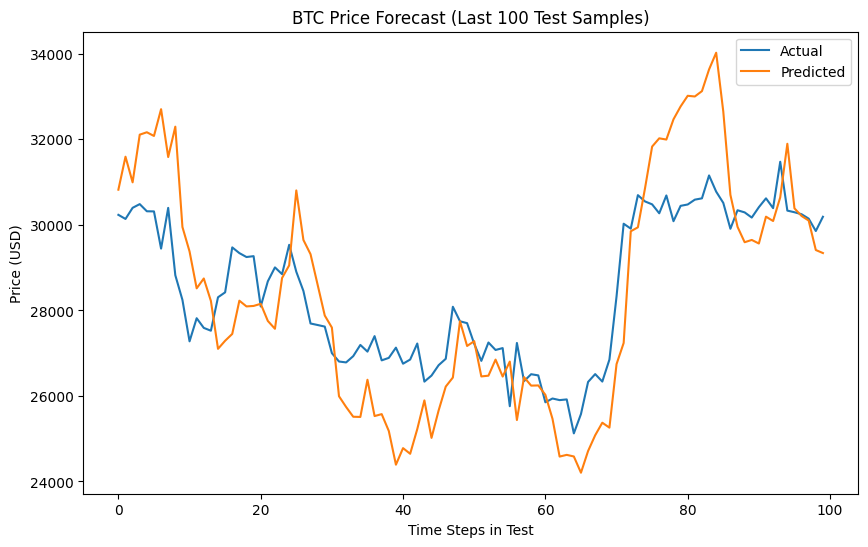

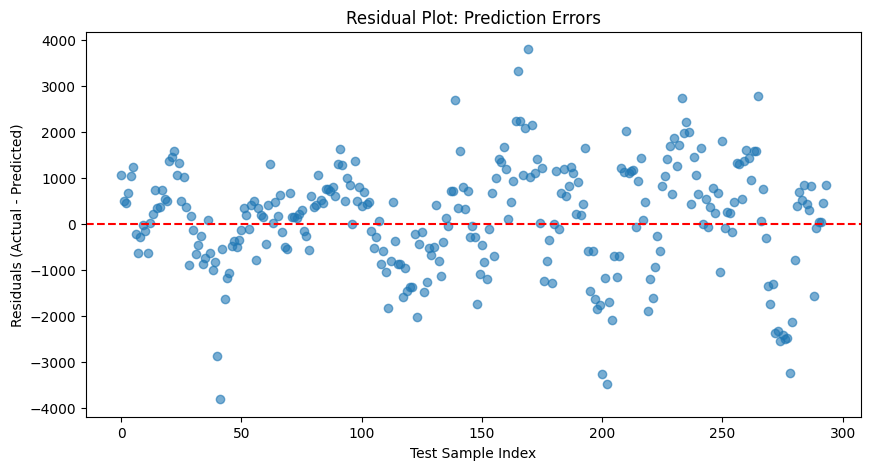

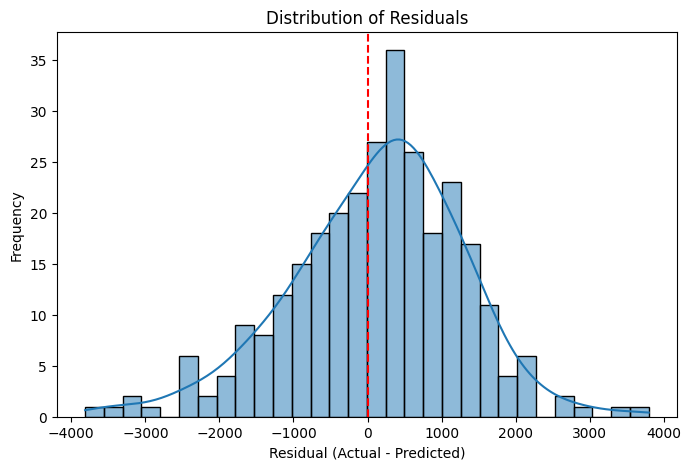

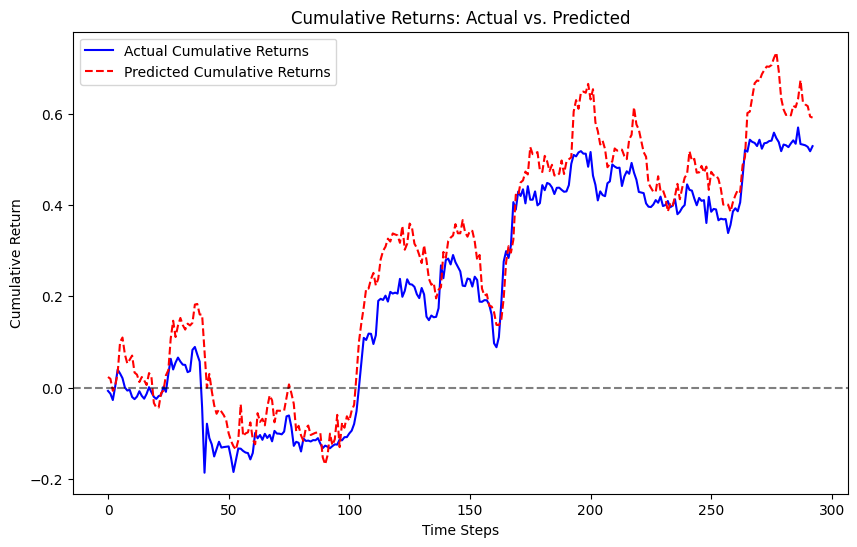

In [ ]:
import seaborn as sns

# Last N predictions vs actual
N_plot = 100
plt.figure(figsize=(10,6))
plt.plot(test_targets_real[-N_plot:], label='Actual')
plt.plot(test_preds_real[-N_plot:], label='Predicted')
plt.title("BTC Price Forecast (Last 100 Test Samples)")
plt.xlabel("Time Steps in Test")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()


# Residual Plot (Prediction Errors)
residuals = test_targets_real - test_preds_real

plt.figure(figsize=(10, 5))
plt.scatter(range(len(residuals)), residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='dashed')  # Zero error line
plt.title("Residual Plot: Prediction Errors")
plt.xlabel("Test Sample Index")
plt.ylabel("Residuals (Actual - Predicted)")
plt.show()


# Histogram of Residuals to see Error Distribution
plt.figure(figsize=(8,5))
sns.histplot(residuals, bins=30, kde=True)
plt.axvline(x=0, color='r', linestyle='dashed')  # Centered at zero
plt.title("Distribution of Residuals")
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Frequency")
plt.show()


# Cumulative Return Comparison
# compares cumulative returns from actual prices vs. predicted prices
actual_returns = np.cumsum(np.diff(test_targets_real) / test_targets_real[:-1])
predicted_returns = np.cumsum(np.diff(test_preds_real) / test_preds_real[:-1])

plt.figure(figsize=(10,6))
plt.plot(actual_returns, label="Actual Cumulative Returns", color='blue')
plt.plot(predicted_returns, label="Predicted Cumulative Returns", color='red', linestyle="dashed")
plt.axhline(y=0, color='black', linestyle='dashed', alpha=0.5)
plt.title("Cumulative Returns: Actual vs. Predicted")
plt.xlabel("Time Steps")
plt.ylabel("Cumulative Return")
plt.legend()
plt.show()